In [1]:
import os
import re
import collections
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

if os.getcwd().endswith('notebook'):
    os.chdir('..')

In [2]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

## Assemblies

In [3]:
assemblies_path = os.path.join(os.getcwd(), 'data/assemblies.csv')
assembly_df = pd.read_csv(assemblies_path, index_col='assembly_accession')
assemblies = np.array(assembly_df.index.tolist())
assembly_df.head()

,taxid,species_taxid,organism_name,domain,phylum,class,order,family,genus,species,strain,assembly_level
assembly_accession,,,,,,,,,,,,
GCA_000010525.1,438753,7,Azorhizobium caulinodans ORS 571,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Xanthobacteraceae,Azorhizobium,Azorhizobium caulinodans,Azorhizobium caulinodans ORS 571,Complete Genome
GCA_000218545.1,593907,11,Cellulomonas gilvus ATCC 13127,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Cellulomonadaceae,Cellulomonas,Cellulomonas gilvus,Cellulomonas gilvus ATCC 13127,Complete Genome
GCA_000020965.1,309799,14,Dictyoglomus thermophilum H-6-12,Bacteria,Dictyoglomi,Dictyoglomia,Dictyoglomales,Dictyoglomaceae,Dictyoglomus,Dictyoglomus thermophilum,Dictyoglomus thermophilum H-6-12,Complete Genome
GCA_000012885.1,338963,19,Pelobacter carbinolicus DSM 2380,Bacteria,Proteobacteria,Deltaproteobacteria,Desulfuromonadales,Desulfuromonadaceae,Pelobacter,Pelobacter carbinolicus,Pelobacter carbinolicus DSM 2380,Complete Genome
GCA_001735525.1,23,23,Shewanella colwelliana,Bacteria,Proteobacteria,Gammaproteobacteria,Alteromonadales,Shewanellaceae,Shewanella,NaN,Shewanella colwelliana,Scaffold


## Plot distribution of distances for a specific strain

In [4]:
e_coli_assembly = assembly_df[assembly_df['organism_name'].str.contains('Escherichia coli')].index[0]
e_coli_assembly

'GCA_000800765.1'

In [5]:
klebsiella_aerogenes_assembly = assembly_df[
    assembly_df['organism_name'].str.contains('Klebsiella aerogenes')
].index[0]
klebsiella_aerogenes_assembly

'GCA_000215745.1'

In [6]:
dictyoglomus_thermophilum_assembly = assembly_df[
    assembly_df['organism_name'].str.contains('Dictyoglomus thermophilum')
].index[0]
dictyoglomus_thermophilum_assembly

'GCA_000020965.1'

In [7]:
def load_gene_dist(assembly):
    gene_dist_path = os.path.join(
        os.getcwd(),
        f'data/sequences/{assembly}/{assembly}_tri_nucleotide_distance_to_mean.csv',
    )
    dist = pd.read_csv(gene_dist_path)
    return dist, dist['distance'].values

In [8]:
def load_genome_wide_distance(assembly):
    dist_path = os.path.join(
        os.getcwd(),
        f'data/tri_nucleotide_dist_genome_wide_with_overlap.csv',
    )
    df = pd.read_csv(dist_path, index_col='assembly_accession')
    return df.loc[assembly].values

In [9]:
def load_protein_families(assembly, query_type):
    source_path = os.path.join(
        os.getcwd(),
        f'data/sequences/{assembly}/{assembly}_{query_type}.csv.gz',
    )
    return pd.read_csv(source_path, index_col='query')

In [10]:
def kl_divergence(p, q, axis=0):
    return scipy.stats.entropy(p, q, axis=axis)


def jensen_shannon_distance(p, q, axis=0):
    m = (p + q) / 2
    a = kl_divergence(p, m, axis)
    b = kl_divergence(q, m, axis)
    return np.sqrt(
        np.clip(
            (a + b) / 2,
            a_min=0,
            a_max=None,
        )
    )

In [238]:
dictyoglomus_thermophilum_pfam = load_protein_families(dictyoglomus_thermophilum_assembly, 'pfam')
dictyoglomus_thermophilum_genes_df, _ = load_gene_dist(dictyoglomus_thermophilum_assembly)

In [11]:
klebsiella_aerogenes_distribution = load_genome_wide_distance(klebsiella_aerogenes_assembly)
dictyoglomus_thermophilum_distribution = load_genome_wide_distance(dictyoglomus_thermophilum_assembly)
e_coli_distribution = load_genome_wide_distance(e_coli_assembly)

klebsiella_aerogenes_distance = jensen_shannon_distance(
    e_coli_distribution, 
    klebsiella_aerogenes_distribution,
)
dictyoglomus_thermophilum_distance = jensen_shannon_distance(
    e_coli_distribution, 
    dictyoglomus_thermophilum_distribution,
)

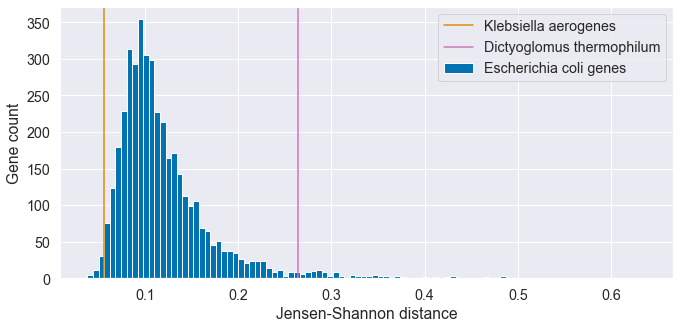

In [12]:
e_coli_genes_df, e_coli_distances = load_gene_dist(e_coli_assembly)

f, ax = plt.subplots(1, 1, figsize=(11, 5))
ax.hist(e_coli_distances, bins=100, label='Escherichia coli genes');
ax.axvline(klebsiella_aerogenes_distance, color=palette[1], label='Klebsiella aerogenes');
ax.axvline(dictyoglomus_thermophilum_distance, color=palette[4], label='Dictyoglomus thermophilum');
ax.legend();
ax.set_xlabel('Jensen-Shannon distance');
ax.set_ylabel('Gene count');
#f.savefig(
#    os.path.join(os.getcwd(), 'report/diagrams/e_coli_distances.eps'), 
#    bbox_inches='tight', 
#    dpi=300,
#)

In [13]:
e_coli_pfam = load_protein_families(e_coli_assembly, 'pfam')
e_coli_pfam.head()

,assembly_accession,protein_id,query_id,label
query,,,,
MreC,GCA_000800765.1,AIZ53040.1,PF04085.14,cell-wall-structural-complex-MreBCD-transmembr...
MreD,GCA_000800765.1,AIZ53039.1,PF04093.12,cell-wall-structural-complex-MreBCD-transmembr...
MR_MLE_C,GCA_000800765.1,AIZ53504.1,PF13378.6,galactonate-dehydratase
MR_MLE_C,GCA_000800765.1,AIZ51372.1,PF13378.6,bifunctional-D-altronate/D-mannonate-dehydratase
MR_MLE_C,GCA_000800765.1,AIZ52590.1,PF13378.6,"glucarate-dehydratase-related-protein,-substra..."


In [14]:
len(e_coli_pfam.loc['PAS'])

11

## Sample accession and plot

In [15]:
def sample_assemblies(assemblies, n_samples, seed=None):
    rs = np.random.RandomState(seed)
    return rs.choice(assemblies, replace=False, size=n_samples)

In [181]:
def plot_domain_distances(
    assembly_df, 
    domain_query, 
    query_type,
    n_samples, 
    tail='left',
    phylum=None,
    n_cols=3, 
    seed=None,
    figsize=(16, 5),
):
    n_cols = np.amin([n_cols, n_samples])
    n_rows = int(np.ceil(n_samples / n_cols))
    
    f, axes_ = plt.subplots(n_rows, n_cols, figsize=(figsize[0], figsize[1] * n_rows))
    
    if n_samples == 1:
        axes = np.array([axes_])
    else:
        axes = axes_.flatten()
        
    n_axes = len(axes)
    
    if phylum is not None:
        assemblies = assembly_df[assembly_df['phylum'] == phylum].index
    else:
        assemblies = assembly_df.index
    
    sampled_assemblies = sample_assemblies(assemblies, n_samples, seed)
    
    for i, assembly in enumerate(sampled_assemblies):
        ax = axes[i]
        if (i+1) > n_axes:
            ax.remove()
            continue
            
        gene_dist_path = os.path.join(
            os.getcwd(),
            f'data/sequences/{assembly}/{assembly}_tri_nucleotide_distance_to_mean.csv',
        )
        gene_dist = pd.read_csv(gene_dist_path)
            
        if query_type == 'pfam':
            source_path = os.path.join(
                os.getcwd(),
                f'data/sequences/{assembly}/{assembly}_pfam.csv.gz',
            )
        else:
            source_path = os.path.join(
                os.getcwd(),
                f'data/sequences/{assembly}/{assembly}_tigr.csv.gz',
            )
            
        domain_source = pd.read_csv(source_path)
        
        protein_ids = domain_source[domain_source['query'] == domain_query]['protein_id'].values

        distances = gene_dist['distance'].values
        ax.hist(distances, bins=100, alpha=1, label='genes');

        mean = np.mean(distances)
        ax.axvline(mean, color=palette[4], alpha=1, label='genes mean', linewidth=3)

        for j, v in enumerate(gene_dist[gene_dist['protein_id'].isin(protein_ids)]['distance'].values):
            if tail == 'left':
                color = 'green' if v < mean else 'red'
            else:
                color = 'green' if v > mean else 'red'
                
            label = None
            if j == 0:
                label = domain_query
                
            ax.axvline(v, color=palette[1], alpha=1, label=label);
            
        if i == 0:
            ax.legend()
            
        ax.set_title(assembly)
        
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        
    return f

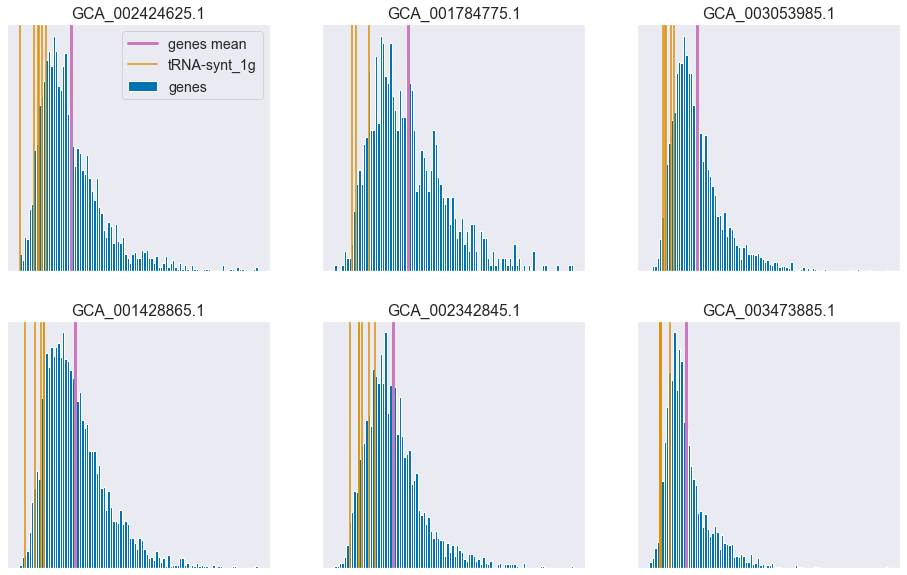

In [17]:
f = plot_domain_distances(
    assembly_df, 
    domain_query='tRNA-synt_1g', 
    query_type='pfam', 
    n_samples=6, 
    #phylum='Firmicutes',
    seed=99,
)
#f.savefig(
#    os.path.join(os.getcwd(), 'report/diagrams/trna_synt_1g_dist.eps'), 
#    bbox_inches='tight', 
#    dpi=300,
#)

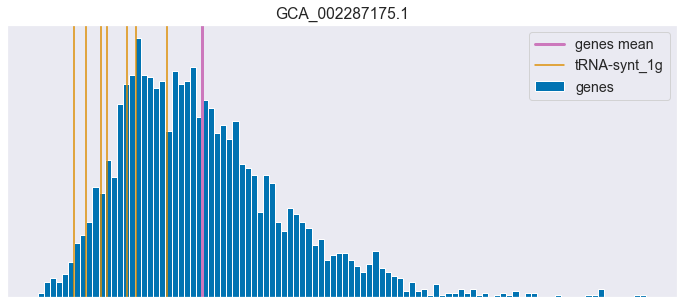

In [190]:
f = plot_domain_distances(
    assembly_df.loc[['GCA_002287175.1']],
    domain_query='tRNA-synt_1g', 
    query_type='pfam', 
    n_samples=1, 
    figsize=(12, 5),
)

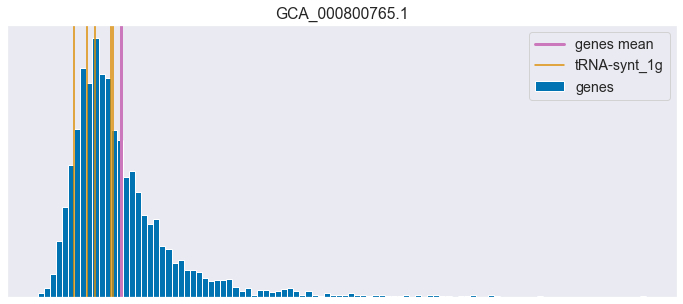

In [191]:
f = plot_domain_distances(
    assembly_df.loc[[e_coli_assembly]], 
    domain_query='tRNA-synt_1g', 
    query_type='pfam', 
    n_samples=1, 
    figsize=(12, 5),
)

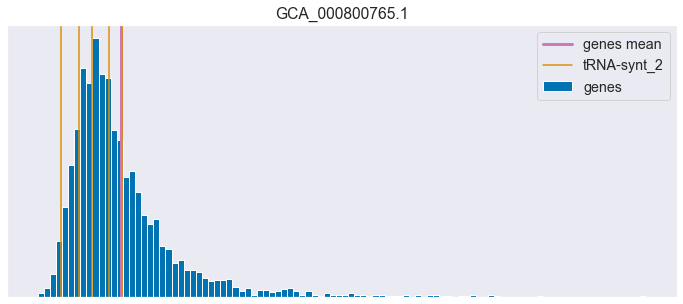

In [215]:
f = plot_domain_distances(
    assembly_df.loc[[e_coli_assembly]], 
    domain_query='tRNA-synt_2', 
    query_type='pfam', 
    n_samples=1, 
    figsize=(12, 5),
)

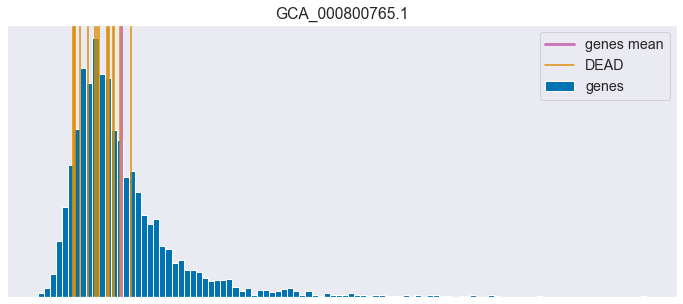

In [221]:
f = plot_domain_distances(
    assembly_df.loc[[e_coli_assembly]], 
    domain_query='DEAD', 
    query_type='pfam', 
    n_samples=1, 
    figsize=(12, 5),
)

In [226]:
e_coli_genes_df[
    e_coli_genes_df['protein_id'].isin(e_coli_pfam.loc['CSD']['protein_id'].values)
].sort_values('distance').head()

,protein_id,distance
814,AIZ54729.1,0.129189
924,AIZ50800.1,0.165774
923,AIZ50799.1,0.173966
1449,AIZ51356.1,0.185247
3326,AIZ53358.1,0.192255


In [210]:
e_coli_genes_df.sort_values('distance').head()

,protein_id,distance
3048,AIZ53054.1,0.038160
672,AIZ54573.1,0.039799
705,AIZ54609.1,0.040075
3710,AIZ53770.1,0.043528
1380,AIZ51284.1,0.043619


In [265]:
e_coli_genes_df[e_coli_genes_df['protein_id'] == 'AIZ53054.1']

,protein_id,distance
3048,AIZ53054.1,0.03816


In [266]:
#e_coli_pfam[e_coli_pfam['protein_id'] == 'AIZ52331.1']
e_coli_pfam[e_coli_pfam['protein_id'] == 'AIZ53054.1']

,assembly_accession,protein_id,query_id,label
query,,,,
SecD_SecF,GCA_000800765.1,AIZ53054.1,PF02355.16,multidrug-efflux-system-protein
ACR_tran,GCA_000800765.1,AIZ53054.1,PF00873.19,multidrug-efflux-system-protein
MMPL,GCA_000800765.1,AIZ53054.1,PF03176.15,multidrug-efflux-system-protein


In [230]:
e_coli_pfam.loc[['HTH_1']]

,assembly_accession,protein_id,query_id,label
query,,,,
HTH_1,GCA_000800765.1,AIZ53162.1,PF00126.27,transcriptional-activator-of-cyn-operon;-autor...
HTH_1,GCA_000800765.1,AIZ52355.1,PF00126.27,DNA-binding-transcriptional-activator-of-3-phe...
HTH_1,GCA_000800765.1,AIZ52224.1,PF00126.27,putative-DNA-binding-transcriptional-regulator
HTH_1,GCA_000800765.1,AIZ51388.1,PF00126.27,putative-DNA-binding-transcriptional-regulator
HTH_1,GCA_000800765.1,AIZ52610.1,PF00126.27,DNA-binding-transcriptional-dual-regulator
...,...,...,...,...
HTH_1,GCA_000800765.1,AIZ53523.1,PF00126.27,putative-DNA-binding-transcriptional-regulator
HTH_1,GCA_000800765.1,AIZ51826.1,PF00126.27,putative-DNA-binding-transcriptional-regulator
HTH_1,GCA_000800765.1,AIZ51793.1,PF00126.27,"bacterial-regulatory-helix-turn-helix,-lysR-fa..."


In [239]:
dictyoglomus_thermophilum_genes_df[
    dictyoglomus_thermophilum_genes_df['protein_id'].isin(
        dictyoglomus_thermophilum_pfam.loc['HD']['protein_id'].values
    )
].sort_values('distance').head()

,protein_id,distance
177,ACI19358.1,0.052410
1568,ACI19615.1,0.053001
803,ACI19252.1,0.057879
1877,ACI19865.1,0.070155
1053,ACI18469.1,0.071285


In [233]:
dictyoglomus_thermophilum_pfam.loc[['HD']]

,assembly_accession,protein_id,query_id,label
query,,,,
HD,GCA_000020965.1,ACI18823.1,PF01966.22,fusion-HD-GYP-domain-and-HD-hydrolase-domain
HD,GCA_000020965.1,ACI18546.1,PF01966.22,putative-response-regulator
HD,GCA_000020965.1,ACI19865.1,PF01966.22,ggdef-domain/hd-domain-protein
HD,GCA_000020965.1,ACI19615.1,PF01966.22,ggdef-domain
HD,GCA_000020965.1,ACI18469.1,PF01966.22,metal-dependent-phosphohydrolase
HD,GCA_000020965.1,ACI18748.1,PF01966.22,sensory-box-protein
HD,GCA_000020965.1,ACI19392.1,PF01966.22,hdig-domain-protein
HD,GCA_000020965.1,ACI18887.1,PF01966.22,sensory-box-protein
HD,GCA_000020965.1,ACI19538.1,PF01966.22,hdig/kh-domain-protein


In [231]:
e_coli_pfam.loc[['HTH_1']]['protein_id'].unique()

array(['AIZ53162.1', 'AIZ52355.1', 'AIZ52224.1', 'AIZ51388.1',
       'AIZ52610.1', 'AIZ52219.1', 'AIZ51804.1', 'AIZ53580.1',
       'AIZ53771.1', 'AIZ51855.1', 'AIZ53572.1', 'AIZ54606.1',
       'AIZ52182.1', 'AIZ51147.1', 'AIZ51456.1', 'AIZ51135.1',
       'AIZ54355.1', 'AIZ53033.1', 'AIZ54751.1', 'AIZ51222.1',
       'AIZ52338.1', 'AIZ54452.1', 'AIZ52915.1', 'AIZ52715.1',
       'AIZ54546.1', 'AIZ53319.1', 'AIZ52107.1', 'AIZ51323.1',
       'AIZ52930.1', 'AIZ52643.1', 'AIZ52901.1', 'AIZ51608.1',
       'AIZ52397.1', 'AIZ54189.1', 'AIZ51357.1', 'AIZ52853.1',
       'AIZ51965.1', 'AIZ51075.1', 'AIZ54478.1', 'AIZ52719.1',
       'AIZ54598.1', 'AIZ53523.1', 'AIZ51826.1', 'AIZ51793.1',
       'AIZ51803.1', 'AIZ53393.1'], dtype=object)

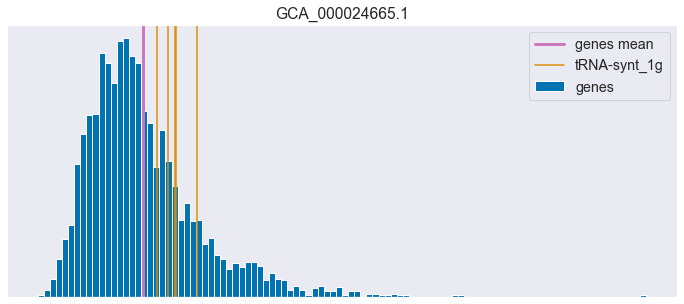

In [192]:
f = plot_domain_distances(
    assembly_df.loc[['GCA_000024665.1']], 
    domain_query='tRNA-synt_1g', 
    query_type='pfam', 
    n_samples=1, 
    figsize=(12, 5),
)

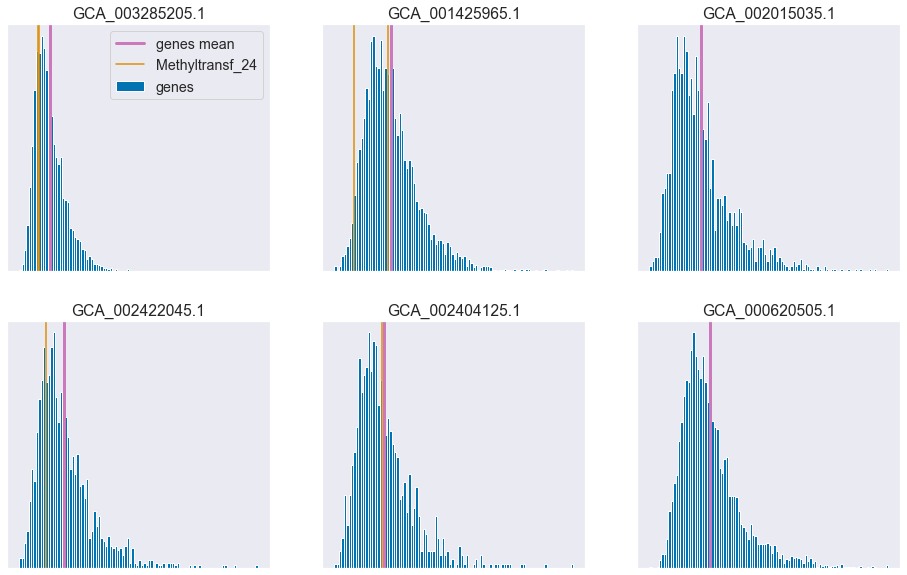

In [18]:
f = plot_domain_distances(
    assembly_df, 
    domain_query='Methyltransf_24', 
    query_type='pfam', 
    n_samples=6, 
    #phylum='Fibrobacteres',
    seed=444,
)
#f.savefig(
#    os.path.join(os.getcwd(), 'report/diagrams/methyltransf_24_dist.eps'), 
#    bbox_inches='tight', 
#    dpi=300,
#)

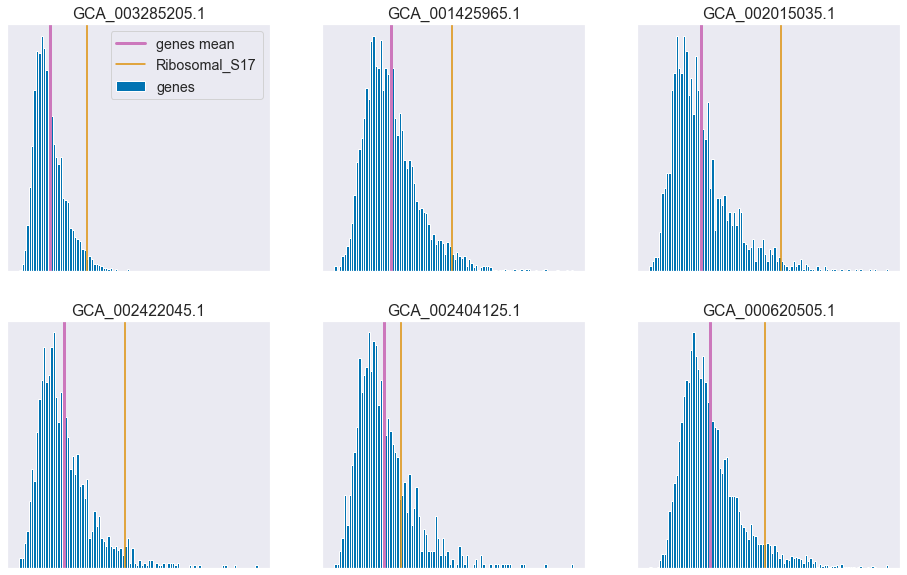

In [19]:
f = plot_domain_distances(
    assembly_df, 
    domain_query='Ribosomal_S17', 
    query_type='pfam', 
    tail='right',
    n_samples=6, 
    seed=444,
)
#f.savefig(
#    os.path.join(os.getcwd(), 'report/diagrams/ribosomal_s17.eps'), 
#    bbox_inches='tight', 
#    dpi=300,
#)

## Evidence count

In [88]:
def compute_phylum_evidence_count(assembly_df, query, query_type, tail):
    counts = collections.defaultdict(int)
    phyla = assembly_df['phylum'].unique()
    for i, phylum in enumerate(phyla):
        if pd.isnull(phylum):
            continue
            
        phylum_p = phylum.lower().replace(' ', '_')
            
        path = os.path.join(
            os.getcwd(),
            f'data/phylum/{phylum_p}/{phylum_p}_{query_type}_probability_{tail}.csv',
        )
        if not os.path.isfile(path):
            continue
            
        df = pd.read_csv(path, index_col='query')
        try:
            evidence = df.loc[query]['evidence_strength']
            counts[evidence] += 1
        except KeyError:
            continue
            
    return dict(counts)

In [89]:
compute_phylum_evidence_count(assembly_df, 'tRNA-synt_1g', 'pfam', 'left')

{'Decisive': 49, 'Substantial': 1, 'Very Strong': 9, 'Strong': 9}

In [33]:
compute_phylum_evidence_count(assembly_df, 'tRNA-synt_1g', 'pfam', 'right')

{'Negative': 68}

In [61]:
compute_phylum_evidence_count(assembly_df, 'tRNA-synt_1', 'pfam', 'left')

Candidatus Diapherotrites


{'Decisive': 44, 'Weak': 1, 'Very Strong': 11, 'Strong': 11, 'Substantial': 1}

In [35]:
compute_phylum_evidence_count(assembly_df, 'tRNA-synt_1', 'pfam', 'right')

{'Negative': 68}

In [23]:
compute_phylum_evidence_count(assembly_df, 'Helicase_C', 'pfam', 'left')

{'Decisive': 55, 'Strong': 5, 'Substantial': 2, 'Very Strong': 6}

In [36]:
compute_phylum_evidence_count(assembly_df, 'Helicase_C', 'pfam', 'right')

{'Negative': 68}

In [68]:
def compute_assembly_evidence_count(assembly_df, query, query_type, tail, phylum):
    counts = collections.defaultdict(int)
    accessions = assembly_df[assembly_df['phylum'] == phylum].index
    for i, accession in enumerate(accessions): 
        path = os.path.join(
            os.getcwd(),
            f'data/sequences/{accession}/{accession}_{query_type}_probability_{tail}.csv',
        )
        if not os.path.isfile(path):
            continue
            
        df = pd.read_csv(path, index_col='query')
        try:
            evidence = df.loc[query]['evidence_strength']
            counts[evidence] += 1
        except KeyError:
            continue
            
    return dict(counts)

In [57]:
compute_assembly_evidence_count(assembly_df, 'tRNA-synt_1g', 'pfam', 'left', 'Fibrobacteres')

{'Negative': 19, 'Weak': 20}

In [69]:
compute_assembly_evidence_count(assembly_df, 'tRNA-synt_1g', 'pfam', 'right', 'Fibrobacteres')

{'Weak': 16, 'Negative': 22, 'Substantial': 1}

In [58]:
compute_assembly_evidence_count(assembly_df, 'tRNA-synt_1', 'pfam', 'left', 'Fibrobacteres')

{'Negative': 20, 'Weak': 18}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


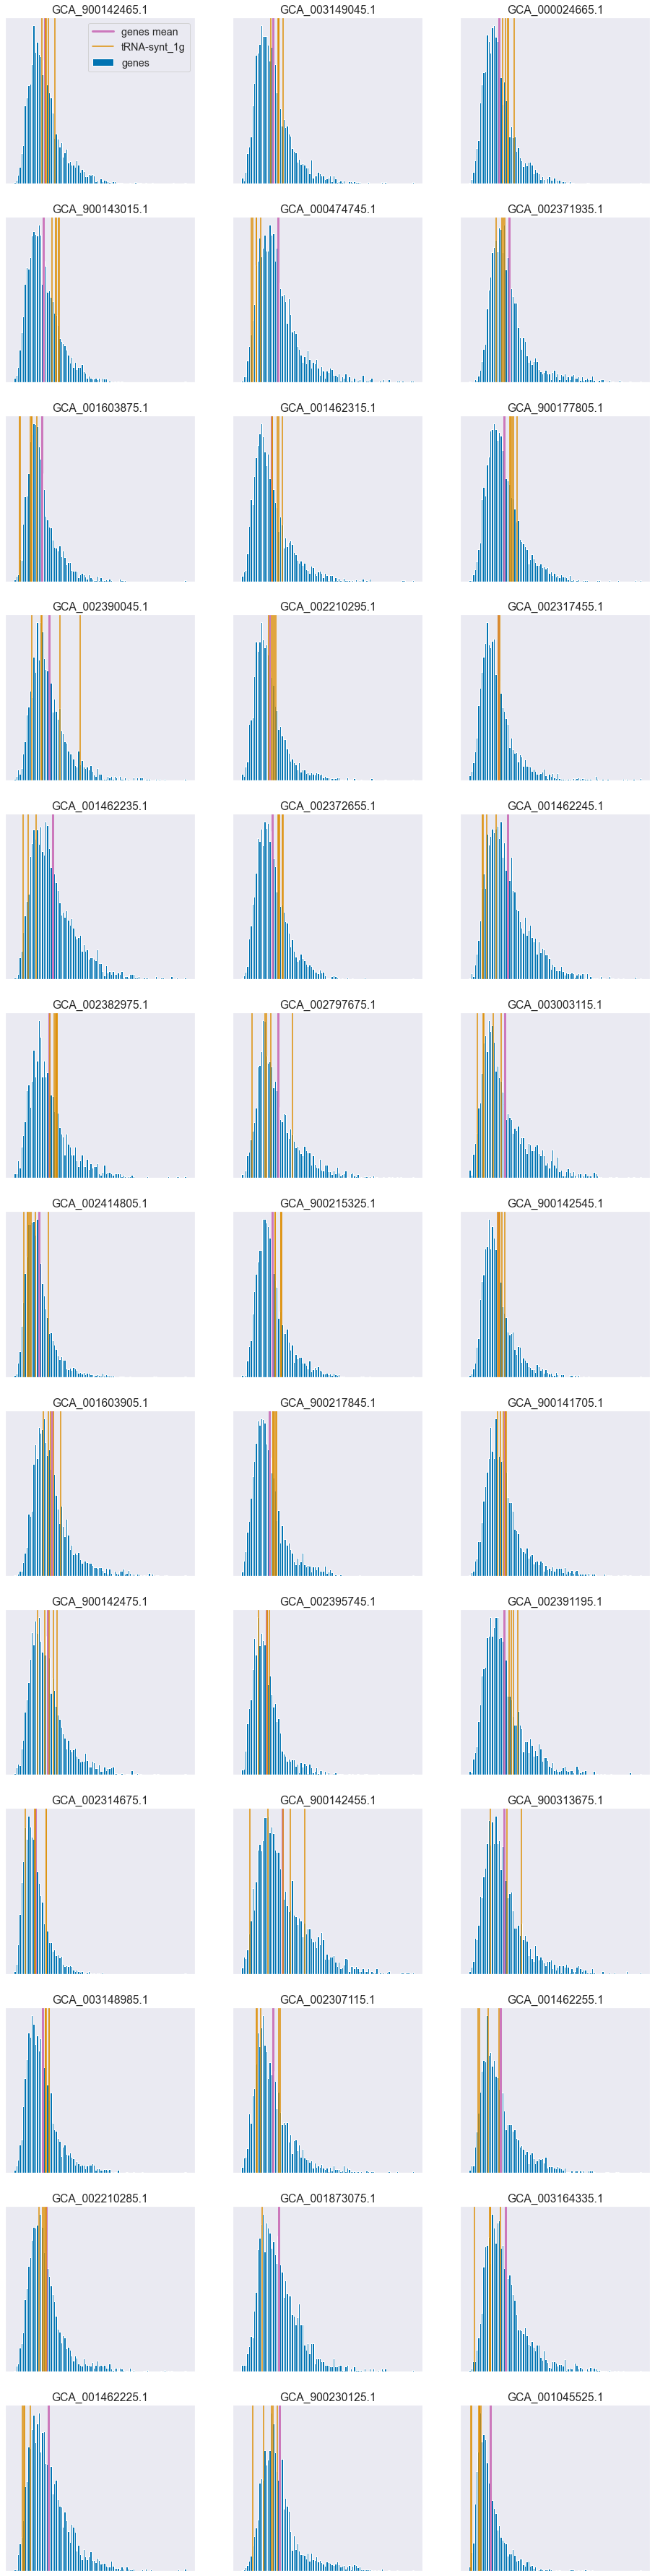

In [59]:
f = plot_domain_distances(
    assembly_df, 
    domain_query='tRNA-synt_1g', 
    query_type='pfam', 
    n_samples=39, 
    phylum='Fibrobacteres',
    seed=444,
)

## Distribution of log evidence 

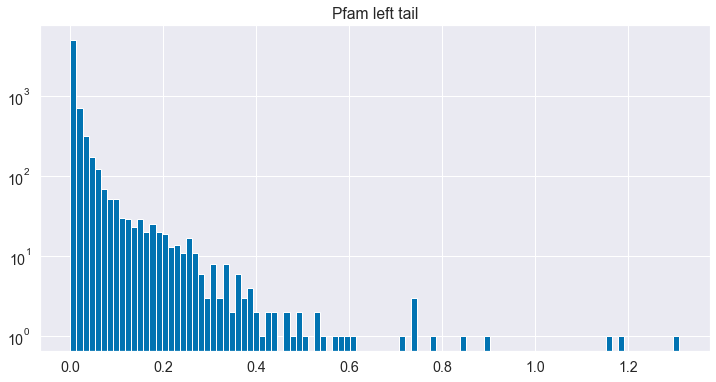

In [25]:
pfam_left_df = pd.read_csv(os.path.join(os.getcwd(), 'data/pfam_probability_left.csv'))
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist([v for v in pfam_left_df['evidence'] if v > 0], bins=100, log=True);
ax.set_title('Pfam left tail');

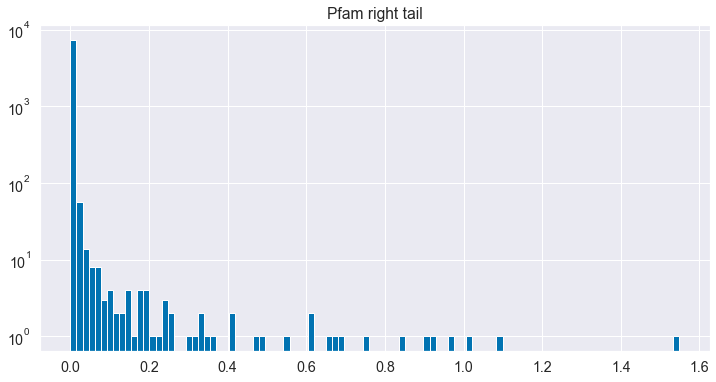

In [26]:
pfam_right_df = pd.read_csv(os.path.join(os.getcwd(), 'data/pfam_probability_right.csv'))
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist([v for v in pfam_right_df['evidence'] if v > 0], bins=100, log=True);
ax.set_title('Pfam right tail');

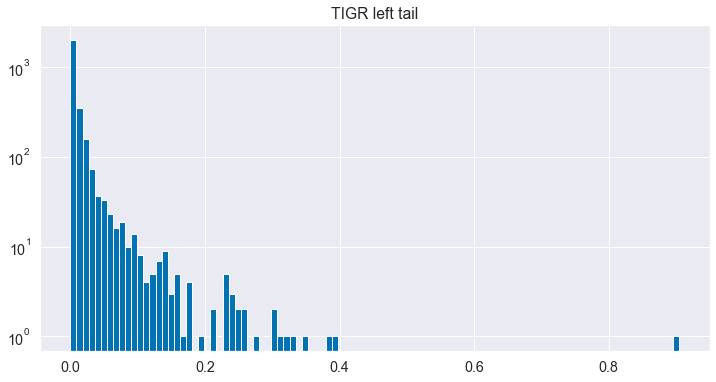

In [27]:
tigr_left_df = pd.read_csv(os.path.join(os.getcwd(), 'data/tigr_probability_left.csv'))
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist([v for v in tigr_left_df['evidence'] if v > 0], bins=100, log=True);
ax.set_title('TIGR left tail');

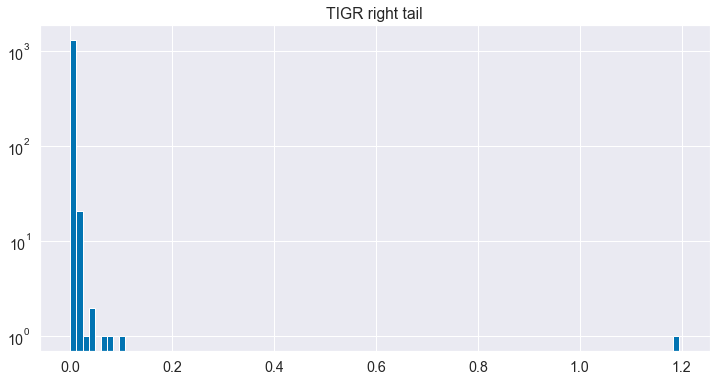

In [28]:
tigr_right_df = pd.read_csv(os.path.join(os.getcwd(), 'data/tigr_probability_right.csv'))
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist([v for v in tigr_right_df['evidence'] if v > 0], bins=100, log=True);
ax.set_title('TIGR right tail');

## Ribsomal proteins

In [152]:
complete_genome_df = assembly_df[
    assembly_df['phylum'].notnull() & 
    (assembly_df['assembly_level'] == 'Complete Genome')
]
main_strains = complete_genome_df.index
len(main_strains)

2584

In [153]:
main_phyla = complete_genome_df['phylum'].unique()
len(main_phyla)

53

In [160]:
rs = np.random.RandomState(444)
main_strains_sample = []
for phylum in main_phyla:
    s = complete_genome_df[complete_genome_df['phylum'] == phylum].index
    main_strains_sample.append(rs.choice(s, size=1, replace=False)[0])

In [165]:
def ribsomal_distance_vs_ecoli(sampled_assemblies, domain_query, query_type):
    e_coli_genes_df, e_coli_distances = load_gene_dist(e_coli_assembly)

    f, ax = plt.subplots(1, 1, figsize=(11, 5))
    ax.hist(e_coli_distances, bins=100, label='Escherichia coli genes');
    
    start = True
    for i, assembly in enumerate(sampled_assemblies):
        gene_dist_path = os.path.join(
            os.getcwd(),
            f'data/sequences/{assembly}/{assembly}_tri_nucleotide_distance_to_mean.csv',
        )
        gene_dist = pd.read_csv(gene_dist_path)
            
        if query_type == 'pfam':
            source_path = os.path.join(
                os.getcwd(),
                f'data/sequences/{assembly}/{assembly}_pfam.csv.gz',
            )
        else:
            source_path = os.path.join(
                os.getcwd(),
                f'data/sequences/{assembly}/{assembly}_tigr.csv.gz',
            )
            
        domain_source = pd.read_csv(source_path)
        
        protein_ids = domain_source[domain_source['query'] == domain_query]['protein_id'].values

        values = gene_dist[gene_dist['protein_id'].isin(protein_ids)]['distance'].values
        
        if len(values) == 0:
            continue
        
        mean_dist = np.mean(values)
        
        label = None
        if start:
            label = f'{domain_query} mean distance'
            start = False
        
        ax.axvline(mean_dist, color=palette[1], alpha=.7, label=label)
    
    ax.legend();
    ax.set_xlabel('Jensen-Shannon distance');
    ax.set_ylabel('Gene count');
    return f, ax

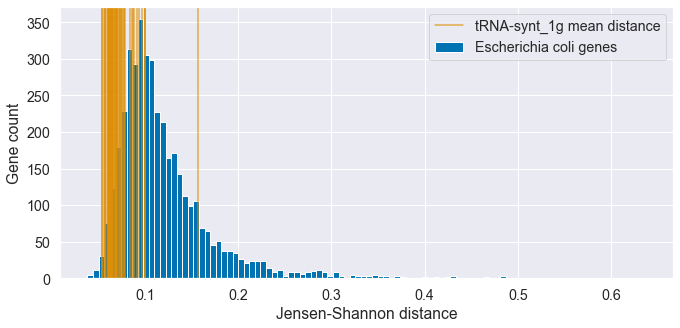

In [170]:
ribsomal_distance_vs_ecoli(main_strains_sample, 'tRNA-synt_1g', 'pfam');

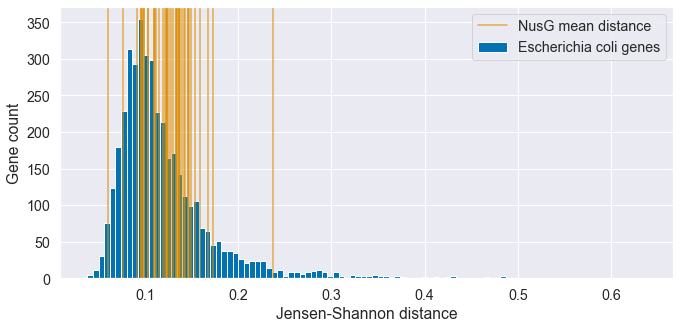

In [171]:
ribsomal_distance_vs_ecoli(main_strains_sample, 'NusG', 'pfam');

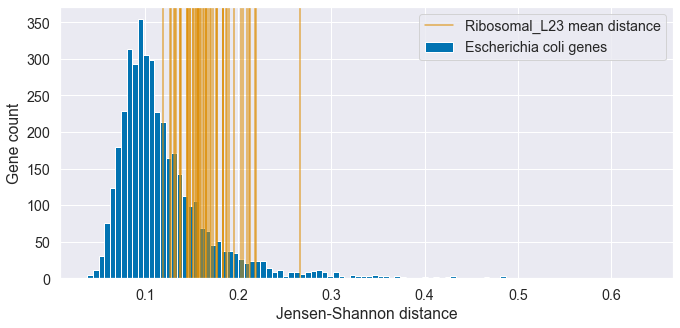

In [166]:
ribsomal_distance_vs_ecoli(main_strains_sample, 'Ribosomal_L23', 'pfam');

## Jensen-Shannon distance vs tAI

In [253]:
def make_map_protein_id_to_gene(assembly):
    protein_id_to_gene = {}
    gene_to_protein_id = {}
    
    match_re_1 = r'.*gene=([^;]+).*protein_id=([^;]+).*$'
    match_re_2 = r'.*protein_id=([^;]+).*gene=([^;]+).*$'

    path = os.path.join(os.getcwd(), f'data/sequences/{assembly}/{assembly}_genomic.gff.gz')
    with gzip.open(path) as f:
        for line in f:
            l = str(line)

            m1 = re.match(match_re_1, l)
            if m1 is not None:
                protein_id_to_gene[m1[2]] = m1[1]
                gene_to_protein_id[m1[1]] = m1[2]
                continue

            m2 = re.match(match_re_2, l)
            if m2 is not None:
                protein_id_to_gene[m2[1]] = m2[2]
                gene_to_protein_id[m2[2]] = m2[1]
                continue
                
    return protein_id_to_gene, gene_to_protein_id

In [254]:
protein_id_to_gene, gene_to_protein_id = make_map_protein_id_to_gene(e_coli_assembly)
len(protein_id_to_gene)

4034

In [257]:
path = os.path.join(os.getcwd(), 'data/raw_tai/Escherichia coli BCT str. K-12 substr..csv')
e_coli_tai = pd.read_csv(path, index_col='Gene')
e_coli_tai.head()

,Unnamed: 0,tAI
Gene,,
aaaD,1,0.214270
aaaE,2,0.221321
aaeA,3,0.226306
aaeB,4,0.208433
aaeR,5,0.212711


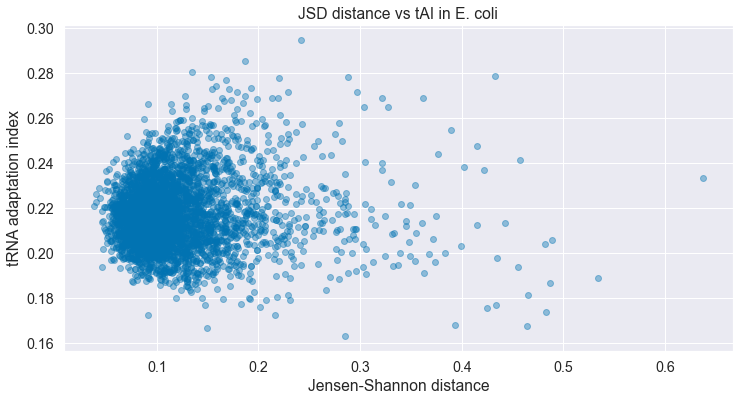

In [263]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))

x, y = [], []
for gene in e_coli_tai.index:
    if gene in gene_to_protein_id:
        tAI = e_coli_tai.loc[gene]['tAI']
        
        df_ = e_coli_genes_df[e_coli_genes_df['protein_id'] == gene_to_protein_id[gene]]
        if len(df_) > 0:
            x.append(df_.iloc[0]['distance'])
            y.append(tAI)
        
ax.scatter(x, y, alpha=0.4);
ax.set_xlabel('Jensen-Shannon distance');
ax.set_ylabel('tRNA adaptation index');
ax.set_title('JSD distance vs tAI in E. coli');

In [264]:
gene_to_protein_id['acrF']

'AIZ53054.1'